In [136]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from thesis.utils import laser_angle_to_id

In [192]:
raw = {}
for kind in ["wall", "floor"]:
    raw[kind] = {}
    for dist in range(1, 6):
        raw[kind][dist] = {}
        for run in range(1, 4):
            raw[kind][dist][run] = np.loadtxt(f"/scratch/users/branisj/distances/{dist}m_{run}_distances_{kind}.txt")

In [193]:
cols = ['Value', 'X', 'Y', 'Z', "unknown", 'Angle', 'Kind', 'Distance', 'Run']
df = pd.DataFrame(columns=cols)
pdfs = []
for kind in ["wall", "floor"]:
    for dist in range(1, 6):
        for run in range(1, 4):
            data = raw[kind][dist][run]
            pdf = pd.DataFrame(data, columns=['Value', 'X', 'Y', 'Z', "unknown", 'Angle'])
            pdf = pdf.drop(columns=["unknown"])
            pdf["Kind"] = kind
            pdf["Distance"] = dist
            pdf["Run"] = run
            pdf = pdf.set_index(["Kind", "Distance", "Run"])

            
            pdfs.append(pdf)


In [194]:
df = pd.concat(pdfs)
df["Laser ID"] = df["Angle"].map(laser_angle_to_id)
df = df.set_index(["Laser ID"], append=True)
df

Value         X         Y         Z  Angle
Kind  Distance Run Laser ID                                               
wall  1        1   0         0.012746  0.454609  0.938299 -0.182794  -15.0
                   1         0.004158  0.460264  0.949794  0.103589    1.0
                   2         0.003651  0.458821  0.946969 -0.147784  -13.0
                   3         0.009431  0.458190  0.945492  0.138719    3.0
                   4        -0.002207  0.461620  0.952724 -0.112148  -11.0
...                               ...       ...       ...       ...    ...
floor 5        3   0        -0.037077  0.540372  4.157680 -1.130210  -15.0
                   0        -0.038916  0.551534  4.148460 -1.128000  -15.0
                   0        -0.037062  0.554977  4.155740 -1.130290  -15.0
                   0        -0.035198  0.568180  4.161680 -1.132630  -15.0
                   0        -0.035195  0.570617  4.161340 -1.132640  -15.0

[8853429 rows x 5 columns]

In [243]:
def plot_per_distance(data, kind):
    kind_data = df.loc[kind]
    fig, axes = plt.subplots(nrows=1, ncols=5)
    fig.set_figwidth(24)
    fig.set_figheight(5)
    means = kind_data.groupby(["Distance", "Angle"]).mean().reset_index()
    std = kind_data.groupby(["Distance", "Angle"]).std().reset_index()
    for dist in range(1, 6):
        _means = means[means["Distance"] == dist].pivot(index='Angle', columns='Distance', values='Value')
        _std = std[std["Distance"] == dist].pivot(index='Angle', columns='Distance', values='Value')
        _means.plot(kind="line", ax=axes[dist-1], title=f"{kind.capitalize()} ({dist}m)", yerr=_std)

# plot_per_distance(df, "wall")
# plot_per_distance(df, "floor")

In [244]:
def plot_per_laser(data, kind):
    kind_data = df.loc[kind]
    fig, axes = plt.subplots(nrows=4, ncols=4)
    fig.set_figwidth(24)
    fig.set_figheight(24)
    means = kind_data.groupby(["Distance", "Angle"]).mean().reset_index()
    std = kind_data.groupby(["Distance", "Angle"]).std().reset_index()
    counter = 0
    for angle in range(-15, 16, 2):
        _means = means[means["Angle"] == angle].pivot(index='Distance', columns='Angle', values='Value')
        _std = std[std["Angle"] == angle].pivot(index='Distance', columns='Angle', values='Value')
        j = counter % 4
        i = counter // 4
        _means.plot(kind="line", ax=axes[i, j], title=f"{kind.capitalize()} ({angle})", yerr=_std)
        counter = counter + 1

# plot_per_laser(df, "wall")
# plot_per_laser(df, "floor")

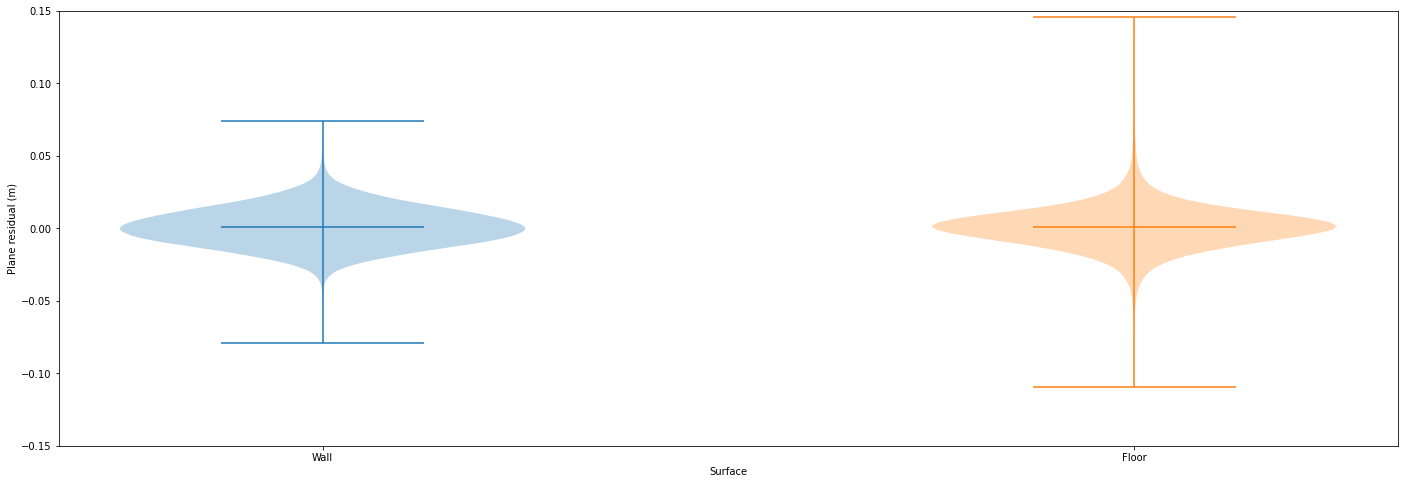

In [251]:
def plot_violin(data):
    fig = plt.figure()
    fig.set_figwidth(24)
    fig.set_figheight(8)
    for i, kind in enumerate(["wall", "floor"]):
        kind_data = df.loc[kind]
        plt.violinplot(kind_data["Value"], positions=[i],showmeans=True)
    plt.xticks([0,1], labels=["Wall", "Floor"])
    plt.ylim(-0.15, 0.15)
    plt.xlabel("Surface")
    plt.ylabel("Plane residual (m)")
    fig.savefig("violins_all.png")
    plt.show()

plot_violin(df)


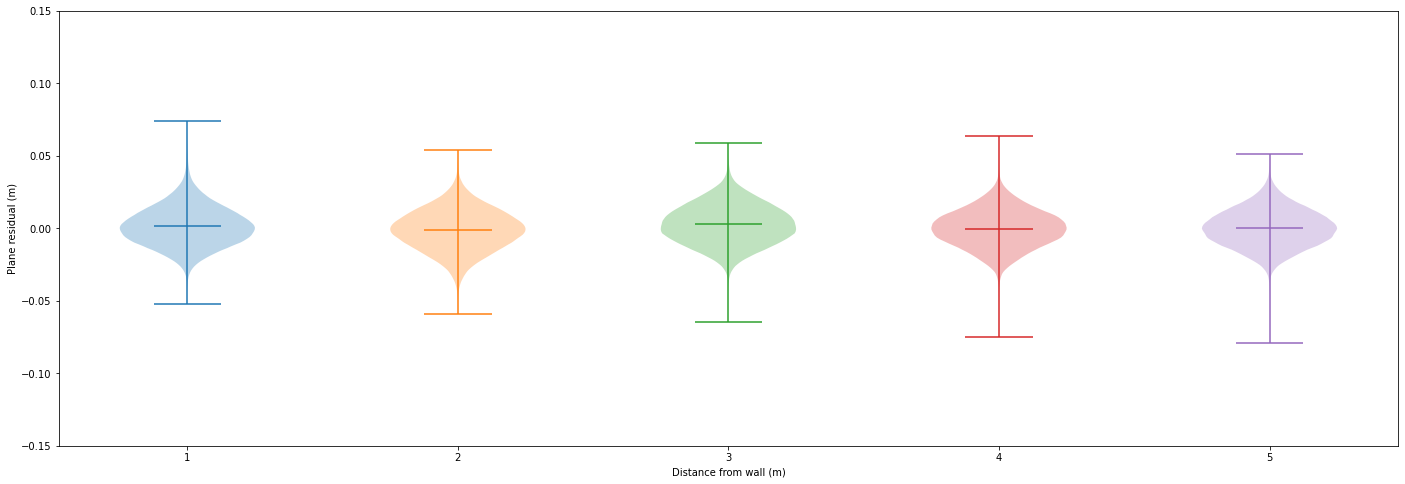

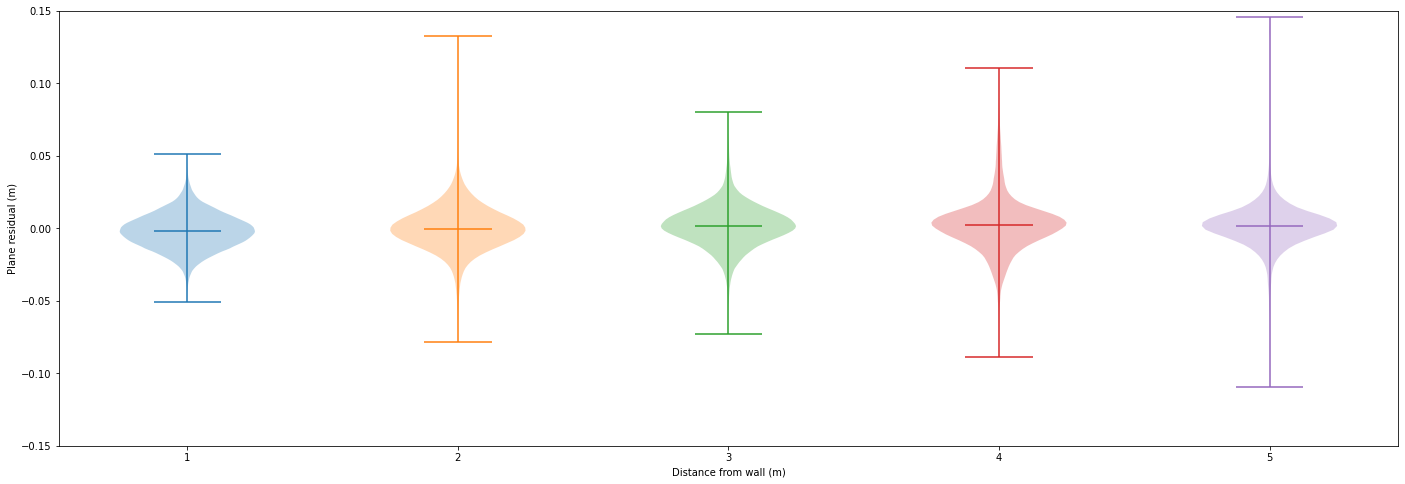

In [254]:
def plot_violin_per_distance(data, kind):
    kind_data = df.loc[kind]
    fig = plt.figure()
    fig.set_figwidth(24)
    fig.set_figheight(8)
    for dist in range(1, 6):
        plt.violinplot(kind_data.loc[dist]["Value"], positions=[dist-1], showmeans=True)
    plt.xticks(range(5), labels=range(1, 6))
    plt.ylim(-0.15, 0.15)
    plt.xlabel("Distance from wall (m)")
    plt.ylabel("Plane residual (m)")
    fig.savefig(f"violins_per_dist_{kind}.png")
    plt.show()

plot_violin_per_distance(df, "wall")
plot_violin_per_distance(df, "floor")

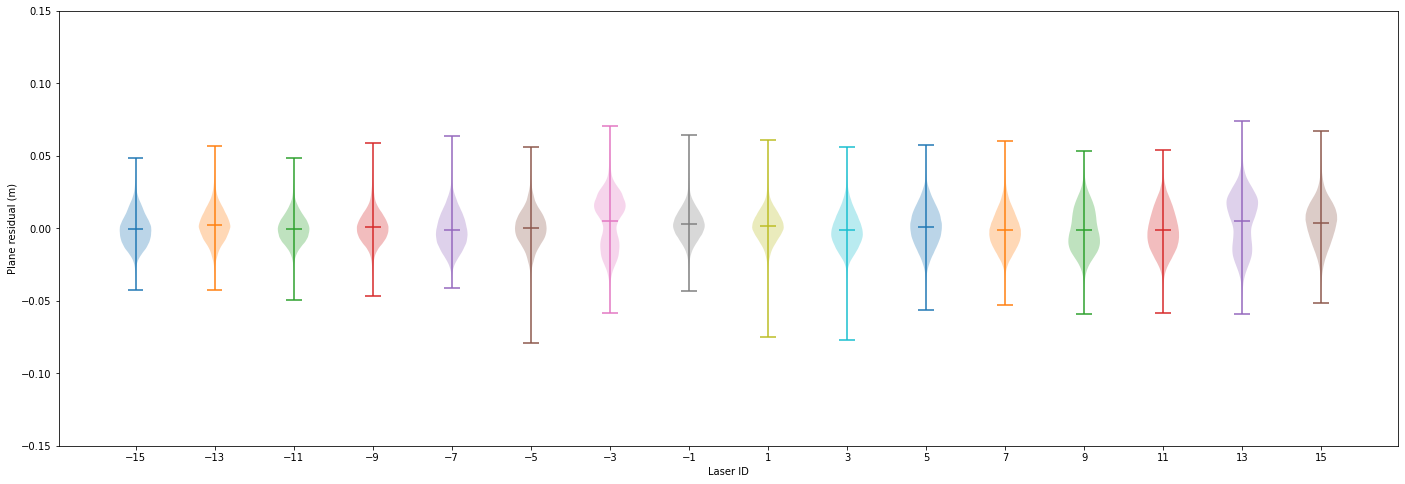

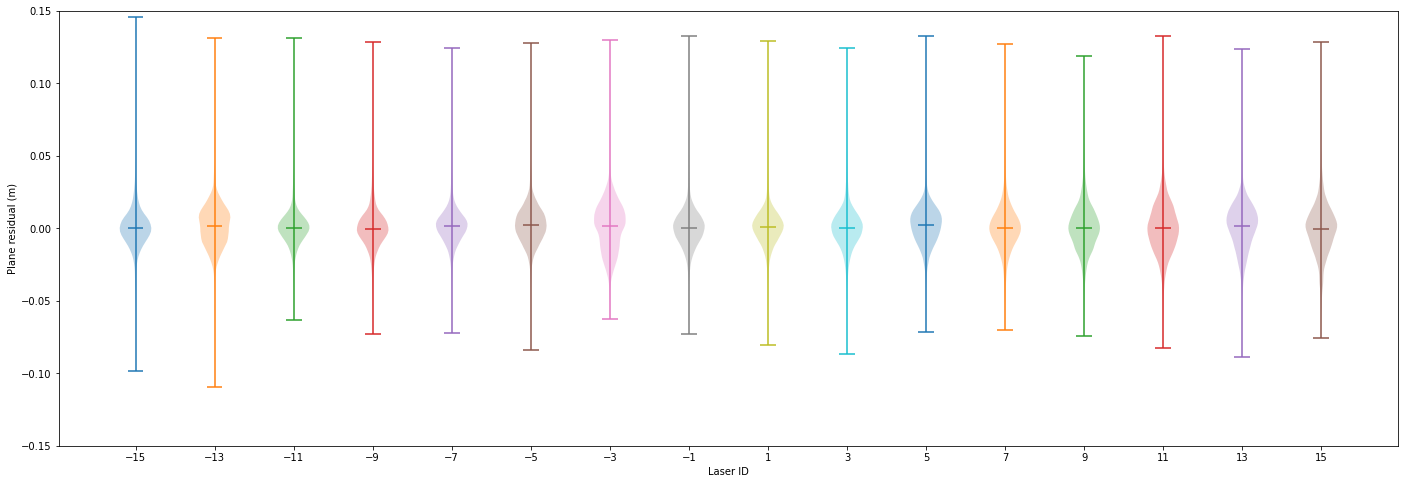

In [255]:
def plot_violin_per_laser(data, kind):
    kind_data = data.loc[kind]
    kind_data = kind_data.swaplevel(0, 3)
    fig = plt.figure()
    fig.set_figwidth(24)
    fig.set_figheight(8)
    for laser in range(-15, 16, 2):
        plt.violinplot(kind_data.loc[laser]["Value"], positions=[laser], showmeans=True, widths=0.8)
    plt.xticks(range(-15, 16, 2))
    plt.ylim(-0.15, 0.15)
    plt.xlabel("Laser ID")
    plt.ylabel("Plane residual (m)")
    fig.savefig(f"violins_per_laser_{kind}.png")
    plt.show()
df2 = df.set_index(["Angle"], append=True)
plot_violin_per_laser(df2, "wall")
plot_violin_per_laser(df2, "floor")

In [191]:
def find_extremes(data, kind):
    kind_data = df.loc[kind]
    display(kind_data.sort_values(by="Value", ascending=False).head(20))

find_extremes(df, "wall")
find_extremes(df, "floor")

Value         X         Y         Z  Angle
Distance Run Laser ID                                               
1        3   13        0.074351  0.936901  0.790673 -0.636818   13.0
             13        0.073932  0.943565  0.784781 -0.767209   13.0
             13        0.073190  0.933380  0.788838 -0.767986   13.0
             13        0.073118  0.920597  0.794870 -0.769701   13.0
             13        0.071142  0.940401  0.783241 -0.765143   13.0
             13        0.071079  0.927832  0.789180 -0.766863   13.0
         2   12        0.070806  0.938603  0.807405 -0.683811   -3.0
         3   13        0.070559  0.774156  0.862313 -0.773851   13.0
         2   13        0.070528  0.892196  0.825022 -0.760122   13.0
         3   13        0.070305  0.917478  0.793283 -0.767604   13.0
             13        0.070067  0.671873  0.910832 -0.778110   13.0
             13        0.069964  0.942676  0.780977 -0.757106   13.0
             13        0.069309  0.907729  0.796854 -0.768040   13.0
             12        0.069151  0.916344  0.790931 -0.862283   -3.0
             13        0.069015  0.830189  0.833579 -0.779756   13.0
             13        0.069013  0.895132  0.802552 -0.769460   13.0
             13        0.068917  0.949224  0.774371 -0.891868   13.0
             13        0.068886  0.940884  0.782778 -0.632034   13.0
         2   13        0.068878  0.829774  0.847771 -0.843067   13.0
         3   12        0.068573  0.894667  0.802435 -0.760843   -3.0

Value         X        Y         Z  Angle
Distance Run Laser ID                                              
5        2   15        0.467938  0.906736  4.20948 -0.722117   15.0
             15        0.273884  0.908892  4.24380 -0.918481   15.0
         1   0         0.146080 -0.045021  4.79635 -1.383630  -15.0
             0         0.145128  0.174039  4.77269 -1.383230  -15.0
             0         0.145055 -0.548686  4.76319 -1.375680  -15.0
             0         0.144803  0.327222  4.76037 -1.383560  -15.0
             0         0.144590  0.277640  4.76366 -1.383090  -15.0
             0         0.144448  0.243167  4.76564 -1.382750  -15.0
             0         0.144437  0.240363  4.76579 -1.382720  -15.0
             0         0.144308  0.207558  4.76743 -1.382390  -15.0
             0         0.144141 -0.465038  4.76785 -1.375860  -15.0
             0         0.144120 -0.511984  4.76326 -1.375100  -15.0
             0         0.144073 -0.092962  4.78820 -1.380630  -15.0
             0         0.143962 -0.142799  4.78716 -1.379980  -15.0
             0         0.143893 -0.176579  4.78616 -1.379530  -15.0
             0         0.143698  0.290578  4.75902 -1.382020  -15.0
             0         0.143369  0.324034  4.75486 -1.381740  -15.0
             0         0.143189 -0.478813  4.76271 -1.374450  -15.0
             0         0.143175 -0.514233  4.75919 -1.373870  -15.0
             0         0.142944 -0.179109  4.78226 -1.378300  -15.0

In [6]:
df.to_pickle("distances.pkl") 

In [7]:
df_lite = df.drop(columns=["X", "Y", "Z"])
df_lite.to_pickle("distances_without_xyz.pkl") 